## Project Overview
## FROM TWEETS TO STRATEGY: PREDICTING SENTIMENT AND SHAPING CUSTOMER ENGAGEMENT
### Business Understanding:
In the current digital landscape, social media platforms such as X (Formerly Twitter)  have become powerful spaces where consumers express their opinions, experiences, and perceptions about brands and products. These online conversations offer organizations a valuable opportunity to measure customer sentiment, evaluate brand perception, and shape strategies that drive competitive advantage. 
The project, “From Tweets to Strategy: Predicting Sentiment and Shaping Customer Engagement,” is motivated by the need for businesses to translate unstructured social media data into actionable insights.

### Business Objectives: 
1. Analyze customer perception of Apple and Google brands, including their products and services.

2. Build a predictive model that classifies sentiments of a tweet.

3. Provide actionable insights that help shape marketing campaigns, improve customer service, and strengthen engagement strategies.

### Target Audience: 

This project is intended for:

a.	Marketing Teams at Apple and Google – to design campaigns that amplify positive sentiment and address negative perceptions.

b.	Customer Engagement & Experience Managers – to strengthen user relationships and improve satisfaction based on sentiment insights.

c.	Product Managers (Apple & Google divisions such as iPhone, Pixel, Android, iOS) – to align product features with consumer expectations revealed in sentiment analysis.

d.	Competitive Strategy Analysts – to benchmark Apple and Google’s brand perception in different product categories and identify opportunities for competitive advantage.

e.	Business Executives & Senior Leadership – to leverage sentiment-driven insights for strategic planning, market positioning, and long-term brand growth.


In [28]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report   
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay   
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score    
from sklearn.metrics import roc_curve
import itertools
from imblearn.over_sampling import SMOTE

from sklearn.svm import SVC
from sklearn.metrics import classification_report

import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download("punkt")
import warnings
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from collections import Counter


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1.0 Loading Dataset

In [2]:
# load the dataset
df = pd.read_csv("Data/judge_tweet_product_company.csv", encoding="latin-1")
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
#.info to show information and structure of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## Data Preprocessing
Missing Values

 - Filled missing product references with a placeholder token ("No_Target")
 - Dropped rows with empty tweets or missing sentiment labels
 

Categorical Standardization

 - Unified sentiment labels into three categories: positive, negative, neutral

 Text Cleaning

 - Converted all tweet text to lowercase

 - Removed URLs, mentions (@user), hashtags, numbers, and special characters


Tokenization & Stopword Removal

 - Split cleaned text into tokens

 - Removed common stopwords to reduce noise

Feature Transformation

 - Applied TF-IDF vectorization to convert text into numerical features for model training




### Filling Missing Values 
The process begins by filling null values from `emotion_in_tweet_is_directed_at ` as this shows although there were emotions in the tweet, it might not have been explicitly directed into specific company or its product 

In [4]:
#Fillna values
df['emotion_in_tweet_is_directed_at']=df['emotion_in_tweet_is_directed_at'].fillna('No_Target')


### Dropping remaining rows with missing values

In [5]:
# Remove rows with any remaining NaN values
df.dropna(inplace=True)

### Categorical Standardization

Next we standardize the values in the column is_there_an_emotion_directed_at_a_brand_or_product. Specifically, we merge the categories "I can't tell" and "No emotion toward brand or product" into a single class labeled "Neutral emotion". This helps simplify the dataset, reduce noise, and make the analysis of emotional direction more consistent

In [6]:
# Standardize the entries in the 'is_there_an_emotion_directed_at_a_brand_or_product' column
df['is_there_an_emotion_directed_at_a_brand_or_product'] = (
    df['is_there_an_emotion_directed_at_a_brand_or_product']
    .replace({
        "I can't tell": "Neutral emotion",
        "No emotion toward brand or product": "Neutral emotion"
    })
)


In [7]:
# standardize the entries in the 'emotion_in_tweet_is_directed_at' column
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


### Tweet text preprocessing
In this step, we clean and standardize the raw tweet text to prepare it for analysis. This involves removing noise such as URLs, mentions, hashtags, special characters, and extra whitespace, as well as converting text to lowercase. These transformations ensure that the text is consistent and easier to tokenize, enabling more accurate sentiment and emotion analysis later on.

In [8]:
# Clean the tweet text
def clean_tweet(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)       # remove URLs
    text = re.sub(r"@", "", text)                    # remove '@' but keep the word
    text = re.sub(r"#", "", text)                    # remove '#' but keep the word
    text = re.sub(r"[^a-z0-9]", " ", text)              # replace / , & - with spaces
    text = re.sub(r"[^a-z\s]", "", text)             # keep only letters
    text = re.sub(r"\s+", " ", text).strip()         # remove extra spaces
    return text


df["clean_tweet"] = df["tweet_text"].apply(clean_tweet)
df.head()


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley i have a g iphone after hrs tweeting at...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipad iphon...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad also they sho...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this year s festival isn t as cras...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...


In [9]:
# Tokenization
df["tokens"] = df["clean_tweet"].apply(word_tokenize)
# Remove stop words
stop_words = set(stopwords.words("english"))
df["tokens"] = df["tokens"].apply(lambda x: [w for w in x if w not in stop_words])
# Lemmatization
lemmatizer = WordNetLemmatizer()
df["tokens"] = df["tokens"].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,clean_tweet,tokens
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley i have a g iphone after hrs tweeting at...,"[wesley, g, iphone, hr, tweeting, rise, austin..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipad iphon...,"[jessedee, know, fludapp, awesome, ipad, iphon..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for ipad also they sho...,"[swonderlin, wait, ipad, also, sale, sxsw]"
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this year s festival isn t as cras...,"[sxsw, hope, year, festival, crashy, year, iph..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri sxsw marissa maye...,"[sxtxstate, great, stuff, fri, sxsw, marissa, ..."


## Exploratory Data Analysis
In this step, the dataset was examined to gain an initial understanding of its structure, distribution, and key characteristics. Summary statistics and visualizations were used to assess the balance of sentiment classes, the frequency of tweets across product categories, and the distribution of tweets between Apple and Google.

### Distibution of tweet sentments 
To better understand how emotions are expressed in the dataset, we examine the distribution of tweet sentiments across the different categories. This helps reveal whether the data is balanced or skewed toward particular sentiment classes, which is important for guiding model selection and evaluation.

In [10]:
# count of each sentiment category
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
Neutral emotion     5544
Positive emotion    2978
Negative emotion     570
Name: count, dtype: int64

### Plotting Tweets Sentiment Distribution

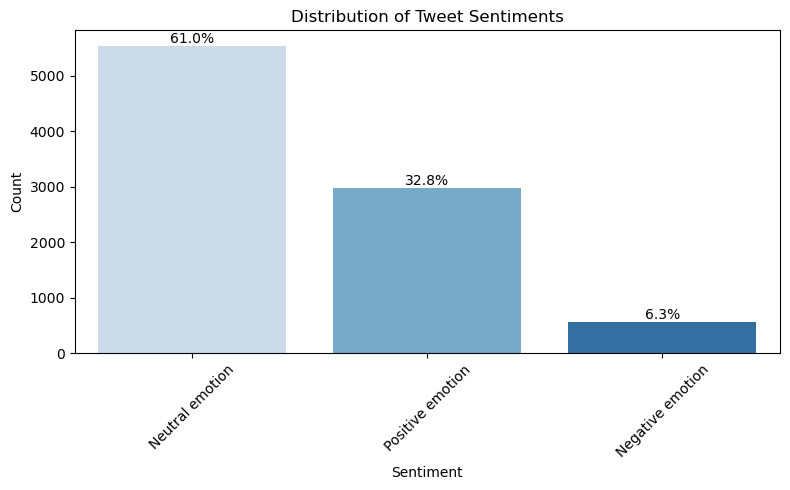

In [11]:
# Distributions of tweet sentiments
# Count values and calculate percentages
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100

# Plot
plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df,
    x='is_there_an_emotion_directed_at_a_brand_or_product',
    order=sentiment_counts.index,
    palette='Blues'
)

# Annotate each bar with percentage
for p in ax.patches:
    label = f"{(p.get_height() / df.shape[0]) * 100:.1f}%"
    ax.annotate(
        label,
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=10,
        color='black'
    )

# Final touches
plt.title('Distribution of Tweet Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



The sentiment distribution indicates that the majority of conversations are neutral, with 5,544 tweets, representing approximately 60.6% of the dataset. This suggests that while consumers are actively discussing brands and products, a large portion of the discourse remains informational or unbiased, lacking strong emotional tones.

Positive sentiment follows with 2,978 tweets (32.6%), highlighting a considerable base of satisfied or supportive consumers who express favorable opinions. Meanwhile, negative sentiment is minimal, at only 570 tweets (6.2%), indicating relatively low levels of dissatisfaction or criticism compared to the overall conversation volume.

Business Implication

The dominance of neutral sentiment suggests that many consumers are either undecided or simply sharing factual content without emotional attachment. This presents an opportunity for brands to convert neutral mentions into positive advocacy through targeted engagement and value-driven messaging. At the same time, it remains essential to monitor and address negative feedback to protect brand reputation and maintain consumer trust.

### Brand Sentiments Analysis

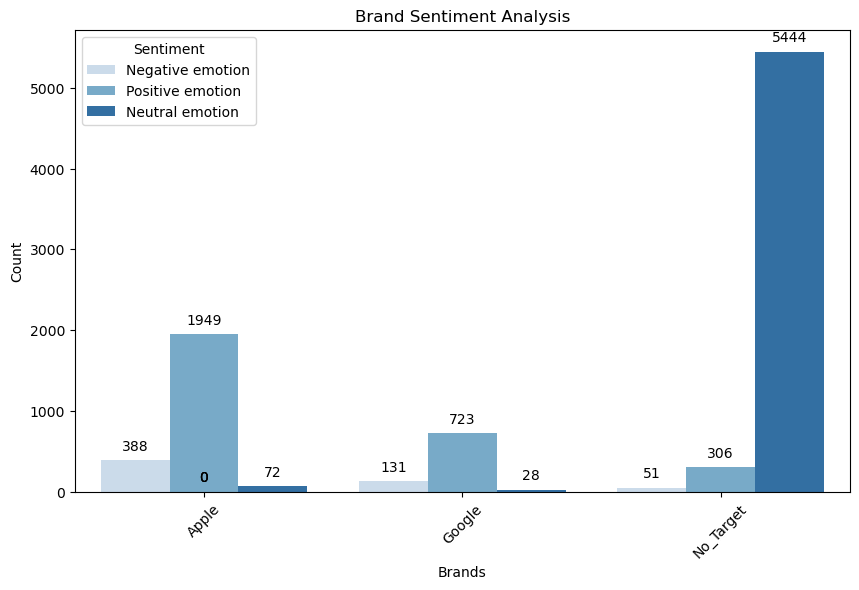

In [30]:
# Normalize Apple products
df['emotion_in_tweet_is_directed_at'] = df['emotion_in_tweet_is_directed_at'].replace(
    {'iPad': 'Apple', 'iPhone': 'Apple','iPad or iPhone App': 'Apple','Other Apple product or service': 'Apple','Android': 'Google','Android App': 'Google','Other Google product or service': 'Google'}
)

# Keep only positive & negative sentiments
filtered = df[df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['Positive emotion', 'Negative emotion', 'Neutral emotion'])]

# Get top 5 categories by total count (pos+neg)
top5_categories = (
    filtered.groupby('emotion_in_tweet_is_directed_at')
    .size()
    .nlargest(5)
    .index
)

# Subset to top 5
subset = filtered[filtered['emotion_in_tweet_is_directed_at'].isin(top5_categories)]

# Plot side-by-side bars
plt.figure(figsize=(10,6))
ax = sns.countplot(
    data=subset,
    x='emotion_in_tweet_is_directed_at',
    hue='is_there_an_emotion_directed_at_a_brand_or_product',  # Positive vs Negative
    palette='Blues'
)

# Add labels on top of bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(height,
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.title('Brand Sentiment Analysis')
plt.xlabel('Brands')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.show()


The analysis reveals that Apple holds a stronger brand perception compared to Google within the dataset. Apple products and the brand generate the highest level of engagement, with 1,949 positive mentions against 388 negative mentions, indicating strong consumer affinity despite some criticism. This suggests that Apple’s visibility and brand equity continue to drive consumer conversations, reinforcing its position as a market leader.

In contrast, Google records 723 positive mentions and 131 negative mentions, reflecting a more modest but consistently favorable brand perception. While Google faces less criticism relative to Apple, the lower engagement volume indicates it does not command the same level of consumer passion or market buzz.

Business implication: Apple’s strong but more polarized presence highlights both its competitive strength and the need to address customer pain points to sustain loyalty. Google, meanwhile, maintains a stable and less contentious perception, but may need to invest in strategies that enhance consumer engagement and brand excitement to match Apple’s market visibility.

## Tweet Length Distribution by Sentiment

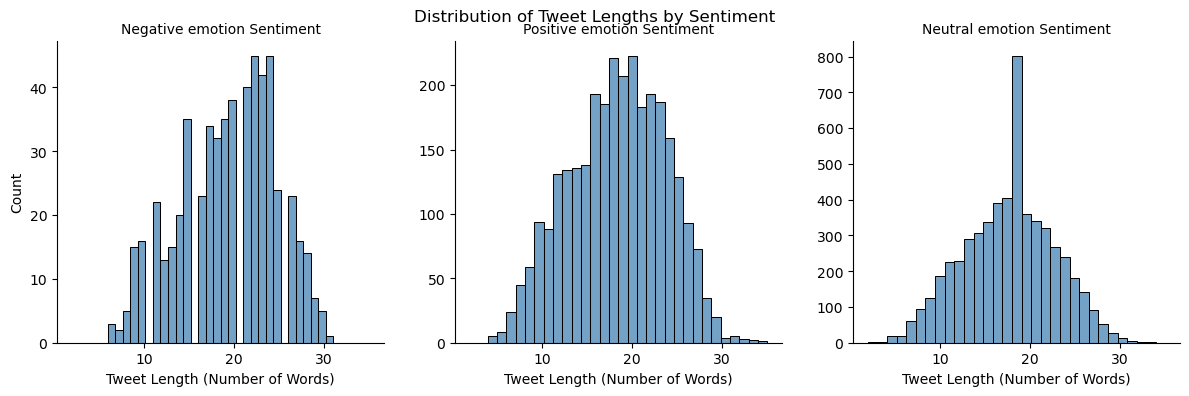

In [13]:
# Add a new column with tweet lengths (if not already created)
df['tweet_length'] = df['clean_tweet'].apply(lambda x: len(str(x).split()))

# Plot histogram for each sentiment separately
g = sns.FacetGrid(
    df, 
    col="is_there_an_emotion_directed_at_a_brand_or_product", 
    col_wrap=3, 
    height=4, 
    sharex=True, 
    sharey=False
)

g.map(sns.histplot, "tweet_length", bins=30, color="steelblue")

g.set_axis_labels("Tweet Length (Number of Words)", "Count")
g.set_titles(col_template="{col_name} Sentiment")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of Tweet Lengths by Sentiment")
plt.show()

Negative Tweets: These fall into distinct groups with a clear peak around 22–24 words. Very short tweets (<10 words) and very long tweets (>30 words) are rare. The distribution is right-skewed, suggesting that while most negative tweets are moderately long, a few extend further in length.
.

Positive Tweets: The curve peaks around 18–20 words, with most tweets ranging between 10 and 26 words. The distribution is also right-skewed, indicating that users tend to use slightly more words when expressing positive sentiment.

Neutral Tweets: These follow a normal distribution with a strong central peak at 18 words, showing a consistent word count pattern. This suggests that neutral tweets are more standardized, possibly because they are more factual or informational.

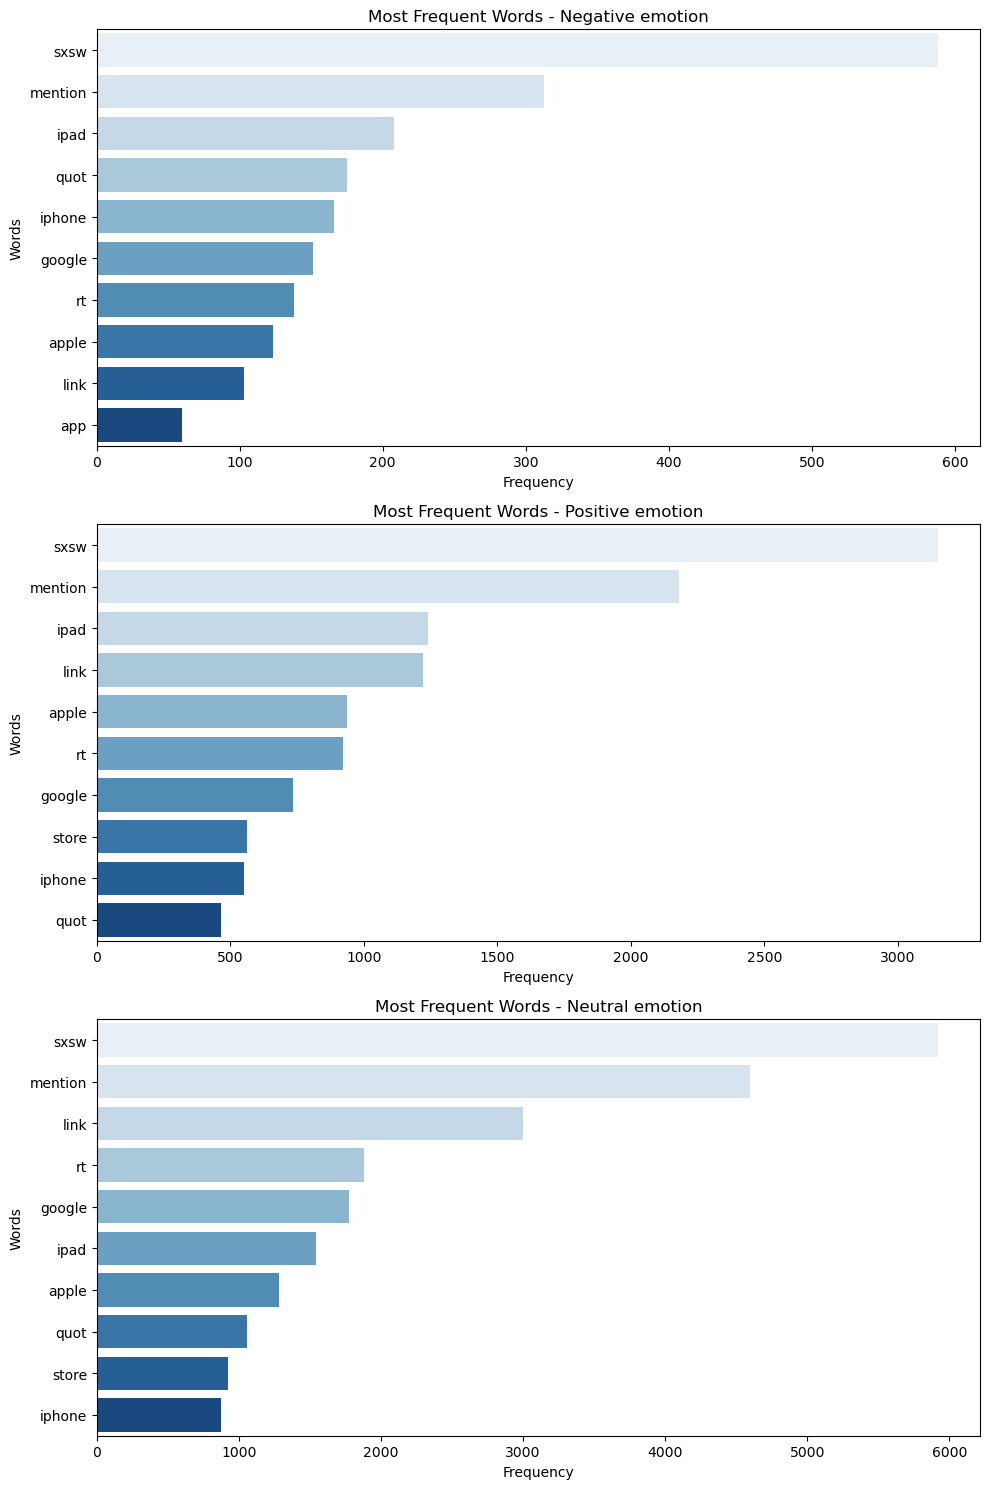

In [14]:


# Function to get most common words for a given sentiment
def get_top_words(df, sentiment_col, tokens_col, sentiment, n=10):
    # Filter by sentiment
    subset = df[df[sentiment_col] == sentiment]
    
    # Flatten tokens
    tokens = [word for tokens in subset[tokens_col] for word in tokens]
    
    # Get frequencies
    freq = Counter(tokens).most_common(n)
    return freq

# Unique sentiment labels
sentiments = df["is_there_an_emotion_directed_at_a_brand_or_product"].unique()

# Setup plots
fig, axes = plt.subplots(len(sentiments), 1, figsize=(10, 5*len(sentiments)))

if len(sentiments) == 1:  # handle case of single sentiment
    axes = [axes]

for i, sentiment in enumerate(sentiments):
    freq = get_top_words(df, "is_there_an_emotion_directed_at_a_brand_or_product", "tokens", sentiment, n=10)
    
    if freq:  # avoid empty plots
        words, counts = zip(*freq)
        sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette="Blues")
        axes[i].set_title(f"Most Frequent Words - {sentiment}")
        axes[i].set_xlabel("Frequency")
        axes[i].set_ylabel("Words")
    else:
        axes[i].set_visible(False)

plt.tight_layout()
plt.show()


The analysis of most frequent words by sentiment shows that discussions on Twitter were largely event-driven, with “sxsw” dominating across negative, positive, and neutral tweets. 

Negative tweets focused on dissatisfaction with the event or frustrations with tech products like the iPad, iPhone, Apple, and Google, highlighting complaints about performance or unmet expectations. 

In contrast, positive tweets reflected enthusiasm and praise for the same event and products, underscoring how shared experiences can generate both excitement and criticism. 

Neutral tweets, meanwhile, were largely informational, consisting of news, updates, and links about SXSW and tech launches, without strong emotional tones. Overall, the findings reveal that major events and product releases act as flashpoints for sentiment on Twitter, producing a mix of praise, criticism, and factual reporting that is quickly amplified through mentions and retweets.

## Modeling Workflow

In [15]:
# mapping sentiment labels to numerical values
sentiment_mapping = {
    'Positive emotion': 1,
    'Negative emotion': -1,
    'Neutral emotion': 0
}

df['sentiment_score'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map(sentiment_mapping)


In [16]:
#split the data into features and target
X = df['clean_tweet']
y = df['sentiment_score']


### Vectorize the Text
- Use TF-IDF to convert tweets into numerical features:

In [17]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X_vectorized = vectorizer.fit_transform(X)

# Now split the vectorized features
x_train, x_test, y_train, y_test = train_test_split(
    X_vectorized, y, test_size=0.2, random_state=42
)


### Train a Baseline Model
- Multinomial Naive Bayes

In [18]:
# Baseline Model – Multinomial Naive Bayes
model = MultinomialNB()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.83      0.04      0.08       121
           0       0.68      0.89      0.77      1092
           1       0.62      0.40      0.49       606

    accuracy                           0.67      1819
   macro avg       0.71      0.44      0.45      1819
weighted avg       0.67      0.67      0.63      1819



The baseline Multinomial Naïve Bayes model achieved an overall accuracy of 67%. It performed well in predicting neutral sentiment (F1 = 0.77, recall = 0.89) but struggled with negative sentiment (F1 = 0.08, recall = 0.04) and showed moderate results for positive sentiment (F1 = 0.49). The imbalance in performance suggests that while the model captures neutral expressions effectively, it has difficulty distinguishing between strongly positive and negative tweets.

### Logistic Regression

In [19]:
# using logistic regression

model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))    


              precision    recall  f1-score   support

          -1       0.90      0.07      0.14       121
           0       0.69      0.88      0.78      1092
           1       0.63      0.45      0.52       606

    accuracy                           0.68      1819
   macro avg       0.74      0.47      0.48      1819
weighted avg       0.69      0.68      0.65      1819



The Logistic Regression model achieved an overall accuracy of 68%, slightly higher than the Naïve Bayes baseline (67%). It performed best on neutral tweets (F1 = 0.77, recall = 0.87), showed moderate performance on positive tweets (F1 = 0.52), and still struggled with negative tweets (F1 = 0.14, recall = 0.07).

Using Support Vector Machine (SVM)

In [20]:
# Using Support Vector Machine (SVM)

model = SVC(kernel='linear')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))    

              precision    recall  f1-score   support

          -1       0.76      0.16      0.26       121
           0       0.70      0.87      0.78      1092
           1       0.63      0.47      0.54       606

    accuracy                           0.69      1819
   macro avg       0.70      0.50      0.52      1819
weighted avg       0.68      0.69      0.66      1819



The Support Vector Machine (SVM) model with a linear kernel achieved an overall accuracy of 69%, which is slightly higher than both Naïve Bayes (67%) and Logistic Regression (68%).

1. Neutral tweets were detected best (F1 = 0.78, recall = 0.87).

2. Positive tweets had moderate performance (F1 = 0.54).

3. Negative tweets improved compared to Logistic Regression (F1 = 0.26 vs. 0.14) but recall remained low (0.16).

### Model Selection

After evaluating three models, Logistic Regression, Multinomial Naive Bayes, and Support Vector Machine (SVM), we chose to proceed with **Logistic Regression** due to its **superior precision** in classifying tweet sentiments. This makes it especially effective for identifying positive sentiment with minimal false positives, aligning well with our goal of extracting reliable brand perception insights.


### Handling Class Imbalance

Exploratory Data Analysis revealed a significant imbalance in sentiment classes, with *neutral* tweets dominating the dataset and *negative* sentiment underrepresented. To address this, we applied Synthetic Minority Oversampling Technique (SMOTE) to rebalance the training set.

By setting `SMOTE`, the model automatically adjusts the importance of each class based on its frequency, penalizing misclassification of minority classes more heavily. This approach helps improve recall and F1-score for underrepresented sentiments without altering the original data distribution.


              precision    recall  f1-score   support

          -1      0.377     0.471     0.419       121
           0      0.753     0.696     0.723      1092
           1      0.564     0.614     0.588       606

    accuracy                          0.654      1819
   macro avg      0.565     0.594     0.577      1819
weighted avg      0.665     0.654     0.658      1819

Accuracy: 0.6536558548653106


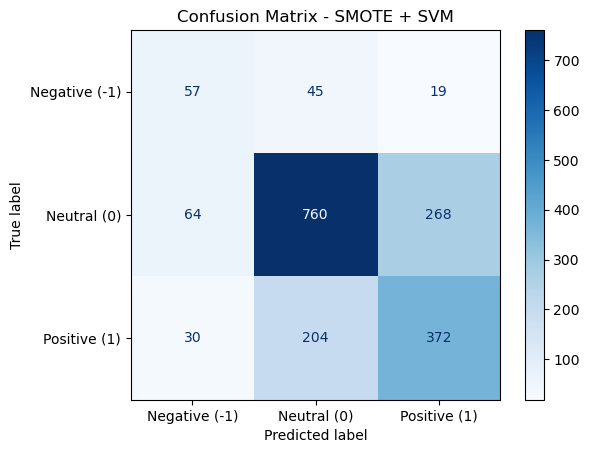

In [31]:
# Step 1: Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Step 2: Train SVM (no need for class_weight since we used SMOTE)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(x_train_resampled, y_train_resampled)

# Step 3: Predictions
y_pred = svm_model.predict(x_test)

# Step 4: Evaluation
print(classification_report(y_test, y_pred, digits=3))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Step 5: Confusion Matrix (with fixed label order)
labels = [-1, 0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (-1)", "Neutral (0)", "Positive (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SMOTE + SVM")
plt.show()


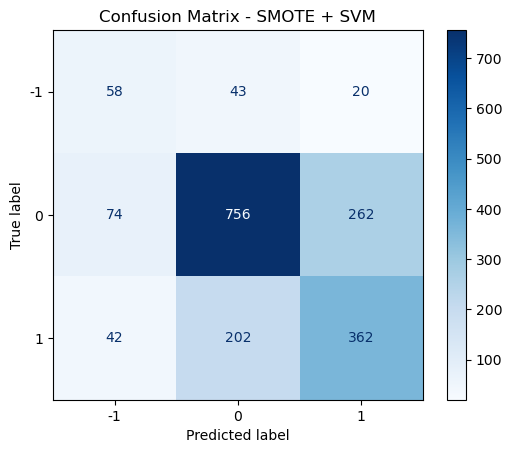

In [29]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - SMOTE + SVM")
plt.show()


In [22]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(x_train_resampled, y_train_resampled)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, digits=3))  
print(accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

          -1      0.330     0.488     0.393       121
           0      0.755     0.690     0.721      1092
           1      0.558     0.592     0.575       606

    accuracy                          0.644      1819
   macro avg      0.548     0.590     0.563      1819
weighted avg      0.661     0.644     0.650      1819

0.6437603078614623


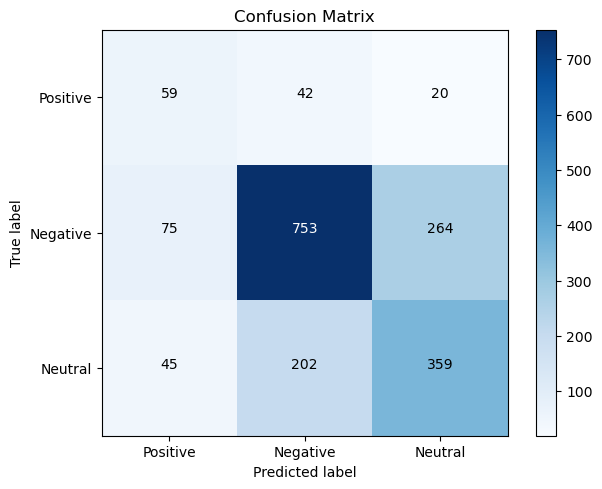

In [23]:
# visualizing the confusion matrix

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Positive", "Negative", "Neutral"])
plt.yticks(tick_marks, ["Positive", "Negative", "Neutral"])
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define a leaner parameter grid
param_grid = {
    'C': [0.01, 0.1, 1],               # Smaller range for faster tuning
    'penalty': ['l1', 'l2'],           # Regularization types
    'solver': ['liblinear', 'saga']    # Compatible solvers
}

# Initialize GridSearchCV without class_weight
grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit the model on SMOTE-resampled data
grid.fit(x_train_resampled, y_train_resampled)

# Evaluate on original test set
y_pred = grid.predict(x_test)
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validated Score:", grid.best_score_)
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validated Score: 0.8119946091644206
              precision    recall  f1-score   support

          -1       0.33      0.48      0.39       121
           0       0.76      0.69      0.72      1092
           1       0.56      0.60      0.58       606

    accuracy                           0.65      1819
   macro avg       0.55      0.59      0.56      1819
weighted avg       0.66      0.65      0.65      1819

Accuracy: 0.6465090709180868


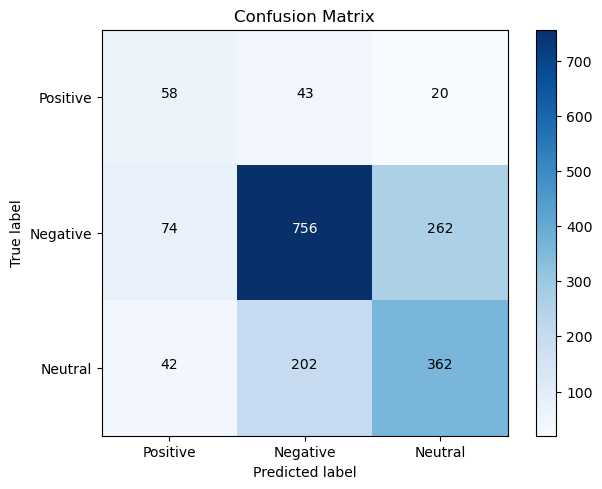

In [25]:
# visualizing the confusion matrix
import matplotlib.pyplot as plt 

cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ["Positive", "Negative", "Neutral"])
plt.yticks(tick_marks, ["Positive", "Negative", "Neutral"])
plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Predicted label")
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()  

| Aspect              | **SVM (Acc: 65.4%)**                                   | **Logistic Regression (Acc: 64.4%)**                                          | **Business Insight**                                                                                                |
| ------------------- | -------------------------------------------------------- | --------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **Negative (-1)**   | F1 = **0.419** (Prec: 0.38, Rec: 0.47)                   | F1 = **0.393** (Prec: 0.33, Rec: 0.49)                          | Logistic Regression catches more complaints (higher recall) but mislabels more (lower precision). Better for **risk monitoring**. |
| **Neutral (0)**     | F1 = **0.723**                                           | F1 = **0.721**                                                  | Stable across runs. Neutral mentions are consistently well classified.                                              |
| **Positive (1)**    | F1 = **0.588**                                           | F1 = **0.575**                                                  | Slightly weaker in Logistic regression, but still good for capturing praise.                                                      |
| **Macro Avg F1**    | **0.577**                                                | **0.563**                                                       | SVM is slightly more balanced across classes.                                                                     |
| **Weighted Avg F1** | **0.658**                                                | **0.650**                                                       | SVM performs a bit better overall.                                                                                |
| **Best Use Case**   | General sentiment dashboards (cleaner, higher accuracy). | Customer service & brand risk alerts (captures more negatives). |                                                                                                                     |


## Recommendations

1. Leverage Neutral Sentiment for Engagement - Since most tweets are neutral, brands should actively convert these mentions into advocacy through personalized responses, storytelling, and targeted campaigns.

2. Improve Detection of Negative Sentiment - Current models underperform on negative tweets. Prioritize real-time monitoring of negative sentiment to address complaints quickly and protect brand reputation.

3. Brand-Specific Strategies - 
- Apple: Strong visibility but polarized opinions. Focus on addressing customer pain points while amplifying advocacy from loyal users.
- Google: Stable but lower engagement. Invest in campaigns that generate excitement to match Apple’s market buzz.

4. Event-Driven Monitoring - Spikes in sentiment were tied to major events (e.g., SXSW). Companies should implement real-time sentiment dashboards to capitalize on product launches, events, and trending topics.

5. Class Imbalance Handling - Continue using SMOTE and resampling techniques to improve recall for minority classes (especially negative sentiment). Consider cost-sensitive learning or ensemble methods to further balance performance.

## Conclusion

This project demonstrates how machine learning can transform unstructured Twitter data into actionable business insights. By comparing Naïve Bayes, Logistic Regression, and SVM, we identified SVM (enhanced with SMOTE and hyperparameter tuning) as the most reliable model for brand sentiment classification.

The results highlight that:

- Neutral tweets dominate, representing untapped opportunities for engagement.
- Positive sentiment is captured moderately well, reflecting brand loyalty and consumer advocacy.
- Negative sentiment detection remains a challenge, requiring advanced NLP techniques for improvement.

Ultimately, this analysis empowers Apple and Google to strengthen customer engagement, design data-driven campaigns, and monitor brand health in real-time, bridging the gap between online conversations and strategic decision-making.